# Behavioral Cloning

In [1]:
import cv2 as cv
import os
import tensorflow as tf
import numpy as np
import pandas as pd

import h5py

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import sample

from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D


Using TensorFlow backend.


In [2]:

## Image Processing Functions

# Multiple (camera) images as input
def read3camerasImg(pathCenter, pathLeft, pathRight, steering, steerAdj = 0.2):
    """
    input: 
        "pathCenter", "pathLeft" and "pathRight" are each a dataframe (nx1) vector of strings, containing the path
        of the saved image
        example: pathCenter[0], pathLeft[0] and pathRight[0]
        data\IMG\center_2018_04_05_13_39_08_155.jpg
        data\IMG\left_2018_04_05_13_39_08_155.jpg
        data\IMG\right_2018_04_05_13_39_08_155.jpg
        
        "steering" is a dataframe vector of double for the steering angle. Left steering is positive, right is negative
        example: steering.iloc[0] = -0.36
    output:
        X, images in numpy array of (n, h, w, d)
        y, steer value in numpy array of size (n, )
    
    """
    assert len(pathCenter) == len(pathLeft) == len(pathRight) == len(steering)
    images3 = []
    steer = []
    nim = len(pathCenter)
    for i in range(nim):
        imgC = cv.cvtColor(cv.imread(pathCenter.iloc[i]), cv.COLOR_BGR2RGB)
        imgL = cv.cvtColor(cv.imread(pathLeft.iloc[i]), cv.COLOR_BGR2RGB)
        imgR = cv.cvtColor(cv.imread(pathRight.iloc[i]), cv.COLOR_BGR2RGB)
        
        # convert 
        # correct steering angle (y) for lect image and right image
        yC = steering.iloc[i]
        yL = yC + steerAdj
        yR = yC - steerAdj
        images3.extend([imgC, imgL, imgR])
        steer.extend([yC, yL, yR])
        
    #print("Images imported: " + str(nim) + " x 3")   
    y = np.array(steer)
    X = np.array(images3)
    return X, y


def flipBatchImg(images, measurement):
    """
    Data augmentation: Create a new set of images by flipping all images and the measurement
    Input:  images:          (n, w, d, channels)
            measurement:     (n, )
            
    Output  newImages        (n, w, d, channels)
            newMeasurement   (n, )
    """
    assert images.shape[0] == measurement.shape[0]
    
    fImages = []
    fMeasurement = []
    
    for i, img in enumerate(images):
        image_flipped = np.fliplr(img)
        measurement_flipped = - measurement[i]
        fImages.append(image_flipped)
        fMeasurement.append(measurement_flipped)
        # if (i%1000==0): print("Images flipped: " + str(i))
        
    newImages = np.array(fImages)
    newMeasurement = np.array(fMeasurement)
        
    return newImages, newMeasurement



In [3]:
## Architecture for the neural network
def MyKerasArchitecture(inputShape, NewSyntax = False ):
    """
    input:   inputShape =                   (160, 320, 3) as example
             NewSyntax  = True              works with Keras 2.x, 
                        = False (default)   works with Keras 1.2.x
    """
    ## Initiate Keras Model and crop data
    input0 = Input(inputShape)
    layer0 = Lambda(lambda x: x/255.0 - 0.5)(input0)

    layer01 = Cropping2D(cropping = ((60,20), (0,0)))(layer0)

    if (NewSyntax):
        # Convolution and Max Pooling layers
        layer1 = Conv2D(9, (6,6), padding='valid', activation = "relu")(layer01)
        layer2 = MaxPooling2D(pool_size=(2,2), padding="valid")(layer1)
    
        layer3 = Conv2D(27, (6,6), padding='valid', activation = "relu")(layer2)
        layer4 = MaxPooling2D(pool_size=(2,2), padding="valid")(layer3)
    
        layer5 = Conv2D(81, (6,6), padding='valid', activation = "relu")(layer4)
        layer6 = MaxPooling2D(pool_size=(2,2), padding="valid")(layer5)
        
        layer7 = Conv2D(81, (3,3), padding='valid', activation = "relu")(layer6)       
    else:
        layer1 = Conv2D(9, 6, 6, border_mode='valid', activation = "relu")(layer01)
        layer2 = MaxPooling2D(pool_size=(2,2), border_mode="valid")(layer1)
        MaxPooling2D()
    
        layer3 = Conv2D(27, 6, 6, border_mode='valid', activation = "relu")(layer2)
        layer4 = MaxPooling2D(pool_size=(2,2), border_mode="valid")(layer3)
    
        layer5 = Conv2D(81, 6, 6, border_mode='valid', activation = "relu")(layer4)
        layer6 = MaxPooling2D(pool_size=(2,2), border_mode="valid")(layer5)
        
        layer7 = Conv2D(81, 3, 3, border_mode='valid', activation = "relu")(layer6)
        
    # Dropout
    #layer8 = Dropout(0.2)(layer7)

    # Flat layer 
    layer8 = Flatten()(layer7)

    # relu(xw +b) of Fully connected layers
    layer9 = Dense(200, activation = "relu")(layer8)
    layer10 = Dense(50, activation = "relu")(layer9)
    layer11 = Dense(1)(layer10)
    
    model = Model(input0, layer11)
    
    return model

## Data

In [4]:
pathdata = "data/"

cnames = ['centerIm', 'leftIm','rightIm','steer','throttle','brake','speed']
df = pd.read_csv(pathdata+"driving_log.csv", names=cnames)
# df.head()

# Read center image
xCenter = df['centerIm']
xLeft  = df['leftIm']
xRight = df['rightIm']
ysteer = df['steer']

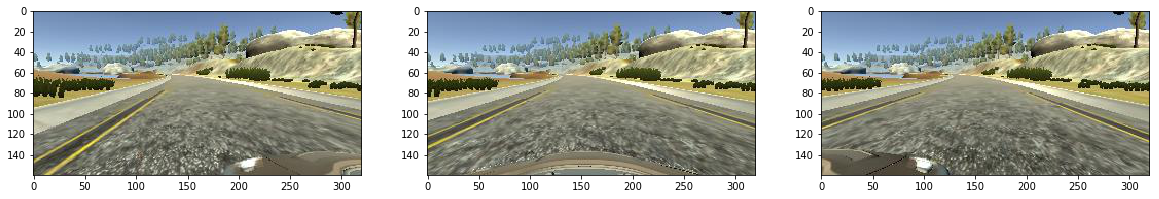

In [15]:
# Save example images in example directory
expath = "example/"
if not os.path.isdir(expath): os.makedirs(expath)

# Note: cv has default BGR. As I read with BGR and write with BGR, no need of color conversion
imgC = cv.cvtColor(cv.imread(xCenter[123]), cv.COLOR_BGR2RGB)
imgL = cv.cvtColor(cv.imread(xLeft[123]), cv.COLOR_BGR2RGB)
imgR = cv.cvtColor(cv.imread(xRight[123]), cv.COLOR_BGR2RGB)
cv.imwrite(expath + "cameraLeft.png", imgL)
cv.imwrite(expath + "cameraRight.png", imgR)
cv.imwrite(expath + "cameraCenter.png", imgC)

fig = plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.imshow(imgL)
plt.subplot(1,3,2)
plt.imshow(imgC)
plt.subplot(1,3,3)
plt.imshow(imgR)
fig.savefig(expath +'cameras3.png', bbox_inches='tight')




## Read All the training data (skip if using the data generator)

In [ ]:
# X, y = read3camerasImg(xCenter, xLeft, xRight, steering=ysteer, steerAdj=0.2)


# n = X.shape[0]
# #sample without replacement. add 1/4 sample where each image is flipped
# select = sample(range(n), int(n/4))

# x1, y1 = model.flipBatchImg(X[select,], y[select,])
# X = np.concatenate((X,x1))
# y = np.concatenate((y,y1))

In [ ]:
# # save once
# # h5f = h5py.File("drivingData.h5", "w")
# # h5f.create_dataset("dataset_X", data = X)
# # h5f.create_dataset("dataset_y", data = y)
# # h5f.close

# # Load data back
# h5f = h5py.File("drivingData.h5", "r")
# X = h5f["dataset_X"][:]
# y = h5f["dataset_y"][:]

## Run model with all data in memory (skip if use Data Generator)

In [ ]:
inputShape = X[0,].shape

mymod4 = MyKerasArchitecture(inputShape)
mymod4.compile(loss="mse", optimizer="adam")

In [ ]:
mf = mymod4.fit(X, y, validation_split=0.2, shuffle=True, epochs = 4)
mymod4.save("model.h5")

In [ ]:
mymod4.summary()

In [ ]:
## Visualize Loss

### print the keys contained in the history object
# print(mf.history.keys())
# print(mf.history)
# print(mf)

### plot the training and validation loss for each epoch
plt.plot(mf.history['loss'])
plt.plot(mf.history['val_loss'])
plt.title('Model Mean Squared Error (MSE) loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()

## Data Generator 

In [6]:
def dataGenerator(df, batch_size = 100, augment=True):
    """
    input:  df      pandas dataframe containing 4 column named
                    centerIm, (string, path of images captured by central camera)
                    leftIm, (string, path of images captured by left camera)
                    rightIm, (string, path of images captured by right camera)
                    steer, (double, steering angle)
    """
    num_samples = df.shape[0]
    samples = range(num_samples)  # each row in dataframe is an example

    while 1: # loops forever, the generator never terminate
        s=shuffle(samples) # random reorder samples
        for offset in range(0, num_samples, batch_size):
            bsample = s[offset:offset+batch_size]
            bdf = df.iloc[bsample, :]
            
            tx, ty = read3camerasImg(pathCenter=bdf['centerIm'], pathLeft=bdf['leftIm'],
                                     pathRight=bdf['rightIm'], steering=bdf['steer'])
            
            if (augment):
                # flip all images. Note: the number of the images is doubled
                #flipselect = sample(batch_size, int(batch_size/2))
                txf, tyf = flipBatchImg(tx, ty)
                tx = np.concatenate((tx,txf))
                ty = np.concatenate((ty,tyf))
                
            # Note: if augment, the size of tx is 6*batch_size, as images from 3 cameras are taken
            #      in augment = False, then 3*batch_size
            
            yield shuffle(tx, ty)

In [7]:
# Compile and train the model using the generator function
n = df.shape[0]

train = sample(range(n), 2*int(n/3))
bsize = 32
trainGenerator = dataGenerator(df.iloc[train], batch_size=bsize)
validGenerator = dataGenerator(df.drop(df.index[train]), batch_size=bsize) # remaining obs

ntrain = 6*len(train)
nval = 6*(n-len(train))
# trainStep = int(ntrain/(6*bsize))
# valStep = int(nval/(6*bsize))

print(ntrain)
print(nval)

inputShape = imgC.shape
mymod5 = MyKerasArchitecture(inputShape)
mymod5.compile(loss="mse", optimizer="adam")


36396
18204


In [8]:
mf5 = mymod5.fit_generator(generator=trainGenerator, samples_per_epoch=ntrain, nb_epoch=6, verbose=1, 
                          validation_data=validGenerator, nb_val_samples=nval)
mymod5.save("model5.h5")

Epoch 1/6
36396/36396 [==============================] - 4211s - loss: 0.0327 - val_loss: 0.0304
Epoch 2/6
36396/36396 [==============================] - 4199s - loss: 0.0280 - val_loss: 0.0301
Epoch 3/6
36396/36396 [==============================] - 4243s - loss: 0.0264 - val_loss: 0.0277
Epoch 4/6
36396/36396 [==============================] - 4585s - loss: 0.0250 - val_loss: 0.0270
Epoch 5/6
36396/36396 [==============================] - 4536s - loss: 0.0234 - val_loss: 0.0263
Epoch 6/6
36396/36396 [==============================] - 4389s - loss: 0.0220 - val_loss: 0.0245


In [10]:
mymod5.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 160, 320, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 75, 315, 9)    981         cropping2d_1[0][0]               
___________________________________________________________________________________________

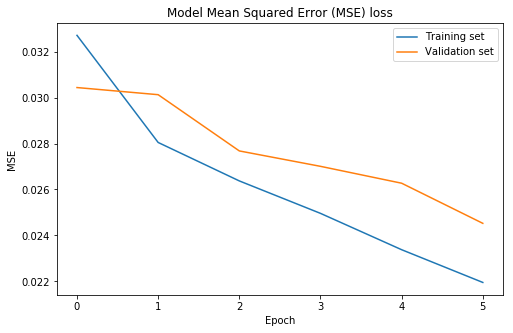

In [18]:
### plot the training and validation loss for each epoch
fig = plt.figure(figsize = (8,5))
plt.plot(mf5.history['loss'])
plt.plot(mf5.history['val_loss'])
plt.title('Model Mean Squared Error (MSE) loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()
fig.savefig(expath +'modelError.png', bbox_inches='tight')